# Computational Biology Set 2
Sander Broos, Nick van Santen

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg
from scipy.integrate import odeint
from scipy import optimize

# %config InlineBackend.figure_formats = ['svg']

In [2]:
# Run cell to increase font sizes. Usefull when saving plots
SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (12,9)

# Question 1

In [2]:
%matplotlib inline

def dRdt(R, S, X, k1 = 2, k2 = 2):
    return k1 * S - k2 * X * R

def dXdt(X, S, R, k3 = 1, k4 = 1):
    return k3 * S - k4 * X

def equilibriumX(k3, k4, S):
    return k3 * S / k4

def equilibriumR(k1, k2, S, X):
    return (k1 * S) / (k2 * X)

def system(y, t, S, k1, k2, k3, k4):
    R, X = y
    
    return np.array([dRdt(R, S, X, k1, k2), dXdt(X, S, R, k3, k4)])

In [3]:
k1 = k2 = 2
k3 = k4 = 1

### 1a

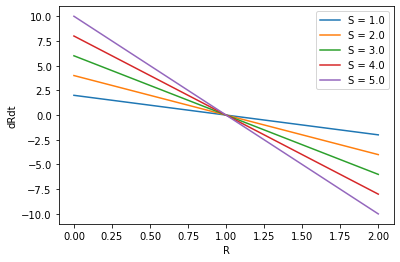

In [4]:
R_values=np.linspace(0, 2, 5000)

for S in np.linspace(1, 5, 5):
    plt.plot(R_values, dRdt(R_values, S, k3/k4 * S), label=f"S = {S}")

plt.xlabel("R")
plt.ylabel("dRdt")
plt.legend()
plt.savefig(f"Figures/1a.png", format="png", dpi=300)
# plt.show()

### 1b

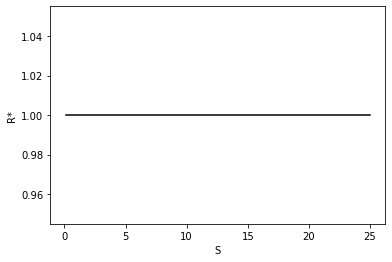

In [5]:
S_values = np.linspace(0.1, 25, 50)
R_values = []

for S in S_values:
    X = equilibriumX(k3, k4, S)    
    R_values.append(equilibriumR(k1, k2, S, X))
    
plt.plot(S_values, R_values, 'k')
plt.xlabel("S")
plt.ylabel("R*")
plt.savefig("Figures/1b.png", format="png", dpi=300)
# plt.show()

### 1c

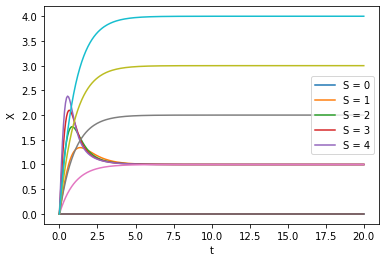

In [6]:
t_values = np.linspace(0, 20, 300)
S_values = range(5)
concentrations = []

for S in S_values:
    concentrations.append(odeint(system, y0 = [0, 0], t = t_values, args = (S, k1, k2, k3, k4)).transpose())

plt.plot(t_values, np.array(concentrations)[:, 0].T, label=f"S = {S}")
plt.xlabel("t")
plt.ylabel("R")
plt.legend([f"S = {S}" for S in S_values])
plt.savefig("Figures/1c_2.png", format="png", dpi=300)
# plt.show()

plt.plot(t_values, np.array(concentrations)[:, 1].T, label=f"S = {S}")
plt.xlabel("t")
plt.ylabel("X")
plt.legend([f"S = {S}" for S in S_values])
plt.savefig("Figures/1c_1.png", format="png", dpi=300)
# plt.show()

# Question 2

In [7]:
from scipy.optimize import fsolve, root

def G(u, v, J, K):
    # Goldbeter-Koshland function
    
    return (2*u*K) / (v - u + v*J + u*K + ((v - u + v*J + u*K)**2 - 4*(v - u)*u*K)**0.5)

class Feedback:        
    def dR_different_S(self, S_values, R_values=np.linspace(0,50, 5000)):
        plt.figure()
        for S in S_values:
            plt.plot(R_values, self.dRdt(R_values, [0, 0], S), label=f"S = {S}")
        plt.xlabel("R")
        plt.ylabel("dRdt")
        plt.legend()
        plt.title(type(self).__name__)
        plt.savefig(f"Figures/2a_dR_{type(self).__name__}.png", format="png", dpi=300)
#         plt.show()
        
    def signal_response_curve(self, S_values, R_values=np.linspace(0, 50, 5000)):
        plt.figure()
        roots = []
        
        for S in S_values:
            dRs = self.dRdt(R_values, 0, S)
            temp = []
            
            for i in range(1, len(dRs)):    
                if dRs[i] * dRs[i-1] < 0:
                    temp.append((R_values[i]+R_values[i-1])/2)
                    
            roots.append(temp)
        
        x = []
        y = []
        for i in range(len(S_values)):
            x.extend([S_values[i]] * len(roots[i]))
            y.extend(roots[i])
        
        plt.xlabel("S")
        plt.ylabel(r"R*")
        plt.title(type(self).__name__)   
        plt.scatter(x, y, s=0.1)
        plt.savefig(f"Figures/2b_{type(self).__name__}.png", format="png", dpi=1000)
#         plt.show()
        
class Homeostasis(Feedback):
    def __init__(self, k0=1,k2=1,k3=0.5,k4=1,J3=0.01,J4=0.01):
        self.k0, self.k2, self.k3, self.k4, self.J3, self.J4 = k0, k2, k3, k4, J3, J4
        
    def E(self, R):
        return G(self.k3, self.k4*R, self.J3, self.J4)
    
    def dRdt(self, R, t, S):
        return self.k0*self.E(R) - self.k2*S*R

class MutualInhibition(Feedback):
    def __init__(self, k0=0,k1=1,k2=0.05,k2prime=0.5,k3=1,k4=0.2,J3=0.05,J4=0.05):  
        self.k0, self.k1, self.k2, self.k2prime, self.k3, self.k4, self.J3, self.J4 = k0, k1, k2, k2prime, k3, k4, J3, J4
        
    def E(self, R):
        return G(self.k3, self.k4*R, self.J3, self.J4)
    
    def dRdt(self, R, t, S):
        return self.k0 + self.k1*S - self.k2*R - self.k2prime*self.E(R)*R

class MutualActivation(Feedback):
    def __init__(self, k0=0.4,k1=0.01,k2=1,k3=1,k4=0.2,J3=0.05,J4=0.05):
        self.k0, self.k1, self.k2, self.k3, self.k4, self.J3, self.J4 = k0, k1, k2, k3, k4, J3, J4
    
    def E(self, R):
        return G(self.k3*R, self.k4, self.J3, self.J4)
    
    def dRdt(self, R, t, S):
        return self.k0*self.E(R) + self.k1*S - self.k2*R

## 2a

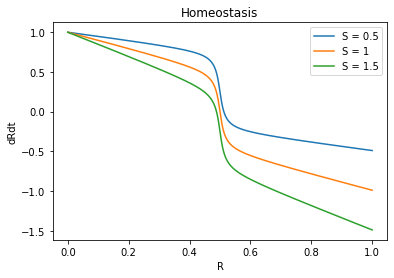

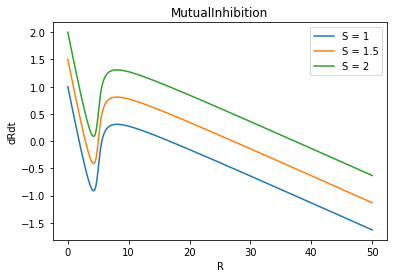

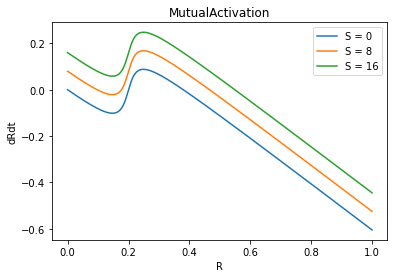

In [8]:
Homeostasis().dR_different_S((0.5,1,1.5), R_values=np.linspace(0,1, 5000))
MutualInhibition().dR_different_S((1,1.5,2), R_values=np.linspace(0,50, 5000))
MutualActivation().dR_different_S((0,8,16), R_values=np.linspace(0,1, 5000))

## 2b

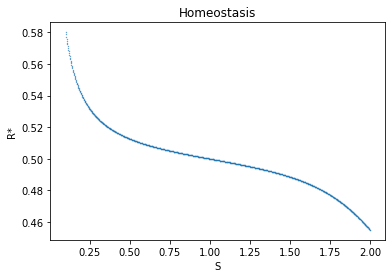

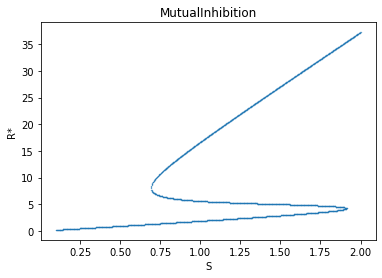

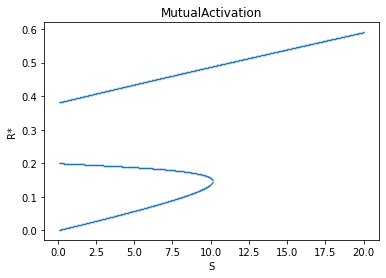

In [9]:
R_precision = 5000
S_precision = 1000 #20000

Homeostasis().signal_response_curve(np.linspace(0.1, 2, S_precision), R_values=np.linspace(0.45, 0.6, R_precision))
MutualInhibition().signal_response_curve(np.linspace(0.1, 2, S_precision), R_values=np.linspace(0, 40, R_precision))
MutualActivation().signal_response_curve(np.linspace(0.1, 20, S_precision), R_values=np.linspace(0, 0.6, R_precision))

# Question 3

In [ ]:
class lac_operon_system:

    def __init__(self, L, Vmax=1, n=5, Km=2, k1=0.05, k2=1, k3=1, k4=1, k5=0.2):

        # Store parameter values
        self.L = L
        self.Vmax = Vmax
        self.n = n
        self.Km = Km
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        self.k4 = k4
        self.k5 = k5

    def dMdt(self, A, M):
        """ Calculates dM/dt for given A and M values. """

        return self.k1 + self.k2 * (1 - (1/(1 + A**self.n))) - self.k3 * M

    def dAdt(self, A, M):
        """ Calculates dA/dt for given A and M values. """

        return self.k4 * M * self.L - self.k5 * A - self.Vmax * M * A / (self.Km + A)

    def nullcline_M(self, A):
        """ 
        Analytical solution for the nullcline of M. The nullcline is written as a
        funtion of A. The nullcline was found by solving dM/dt=0.
        """

        return (self.k1 + self.k2 * (1 - 1/(1 + A**self.n))) / self.k3

    def nullcline_A(self, A):
        """ 
        Analytical solution for the nullcline of A. The nullcline is written as a
        funtion of A. The nullcline was found by solving dA/dt=0.
        """

        return self.k5 * A / (self.k4 * self.L - (self.Vmax * A) / (self.Km + A))

    def root_func(self, x):
        """ This function is required for root finding and odeint. x is a vector [A, M]. """
        
        A, M = x
        return [self.dAdt(A, M), self.dMdt(A, M)]

    def odeint_func(self, x, t):
        """ 
        This function is required for odeint. x is a vector [A, M]. 
        t is not used but required for odeint.
        """
       
        return self.root_func(x)

    def evolve_system(self, x0, ts):
        """
        Evolve the system given initial conditions x0 = [A0, M0] 
        for the given time values ts.
        """

        return odeint(self.odeint_func, x0, ts)

    def obtain_equilibrium_points(self, A_values):
        """
        Obtains the equilibrium points of the system. Scipy.root initially found equilibrium 
        points which are in fact not equilibrium points, but were almost. Therefore first ranges
        are determined at which a root can be found. Then scipy.root is used to find the
        exact equilibrium point within this range.
        """

        equilibrium_points = []

        # Substract the nullclines from eachother. An equilibrium point is present
        # when these values cross zero.
        values = [self.nullcline_A(A) - self.nullcline_M(A) for A in A_values]
       
        for i in range(len(values) - 1):

            # Check if the values cross zero
            if values[i] * values[i + 1] > 0:
                continue
            
            A_lower, A_upper = A_values[i], A_values[i + 1]

            # Compute the values for M given A_lower and A_upper
            M_values = [self.nullcline_M(A_lower), self.nullcline_M(A_upper)]
            M_lower, M_upper = min(M_values), max(M_values)

            # Inititial guess is the middle value for A and M
            A0 = (A_lower + A_upper) / 2
            M0 = (M_lower + M_upper) / 2

            sol = optimize.root(self.root_func, [A0, M0])
            A_sol = sol.x[0]
            M_sol = sol.x[1]

            if not (A_lower < A_sol < A_upper and M_lower < M_sol < M_upper):
                print("Warning: root function found solution outside the expected range")
                continue
            
            equilibrium_points.append([A_sol, M_sol])

        return np.array(equilibrium_points)

    def jacobian(self, x):
        """
        The analytical jacobian of the system. x is a vector [A, M].

        J = [[ (dA/dt)/dA,   (dA/dt)/dM],
             [ (dM/dt)/dA,   (dM/dt)/dM]]
        """

        A, M = x
        J = [[-self.k5  - self.Vmax * M * self.Km / (self.Km + A) ** 2, 
               self.k4 * self.L - self.Vmax * A / (self.Km + A)],
             [ self.n * self.k2 * A ** (self.n - 1) / (1 + A ** self.n) ** 2, 
              -self.k3]]

        return np.array(J)

    def plot_streamplot(self, As, Ms):
        """
        Plots the streamplot for the values in As and Ms. Additionally, adds
        the nullcline and equilibrium points.
        """

        # Compute the change of M and A for all values in the lists Ms and As
        x_velocities, y_velocities = [], []
        for M in Ms:

            x_temp, y_temp = [], []
            
            for A in As:
                x_temp.append(self.dAdt(A, M))
                y_temp.append(self.dMdt(A, M))

            x_velocities.append(x_temp)
            y_velocities.append(y_temp)

        # Compute nullclines for dm/dt=0 and da/dt=0
        a_nulls = self.nullcline_A(As)
        m_nulls = self.nullcline_M(As)

        # Compute equilibrium points
        equilibrium_points = self.obtain_equilibrium_points(As)

        x_velocities = np.array(x_velocities)
        y_velocities = np.array(y_velocities)

        plt.ylim(Ms[0], Ms[-1])
        plt.streamplot(As, Ms, x_velocities, y_velocities, density=1.5)

        plt.plot(As, m_nulls, label="dm/dt = 0")
        plt.plot(As, a_nulls, label="da/dt = 0")
        
        plt.scatter(equilibrium_points[:,0], equilibrium_points[:, 1], marker="o", alpha=1, s=50, linewidths=3, label="equilibrium points")

        plt.xlabel("A")
        plt.ylabel("M")

        plt.legend()
        plt.show()

    def calc_equilibrium_point_eigenvalues(self, As):
        """
        Computes the eigenvalues of the jacobian at the equilibrium points. These 
        eigenvalues are used to identify the equilibrium points.
        """

        equilibrium_points = self.obtain_equilibrium_points(As)
        
        if len(equilibrium_points) == 0:
            print("Warning: No equilibrium points found")
            return

        print("Equilibrium point: eigenvalues")
        for equilibrium_point in equilibrium_points:

            jacob = self.jacobian(equilibrium_point)
            
            eigenvalues = linalg.eigvals(jacob)

            print(f"{equilibrium_point}: {eigenvalues}")

## Question 3b & 3c

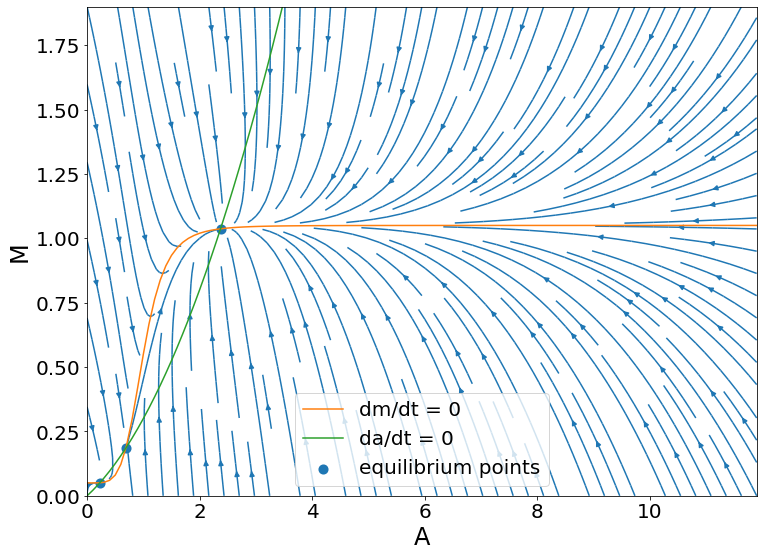

Equilibrium point: eigenvalues
[0.22721313 0.05060521]: [-0.20536235 -1.01504101]
[0.69070572 0.18584858]: [ 0.25284363 -1.50418374]
[2.37172027 1.03684976]: [-0.29085332 -1.01764952]


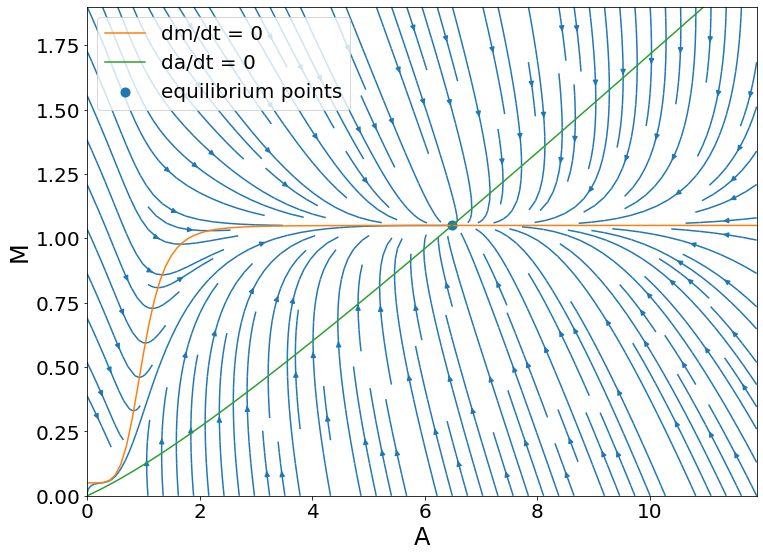

Equilibrium point: eigenvalues
[6.48669311 1.04991293]: [-0.22904699 -1.00010755]


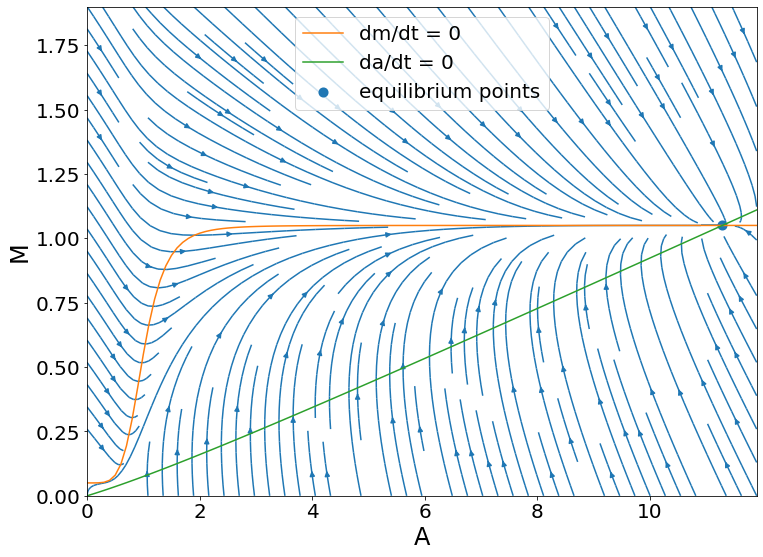

Equilibrium point: eigenvalues
[11.29000859  1.04999455]: [-0.21188299 -1.00000659]


In [ ]:
As = np.arange(0, 12, 0.1)
Ms = np.arange(0, 2, 0.1)

Ls = [1, 2, 3]

for L in Ls:
    system = lac_operon_system(L)
    system.plot_streamplot(As, Ms)
    system.calc_equilibrium_point_eigenvalues(As)

## Question 3d

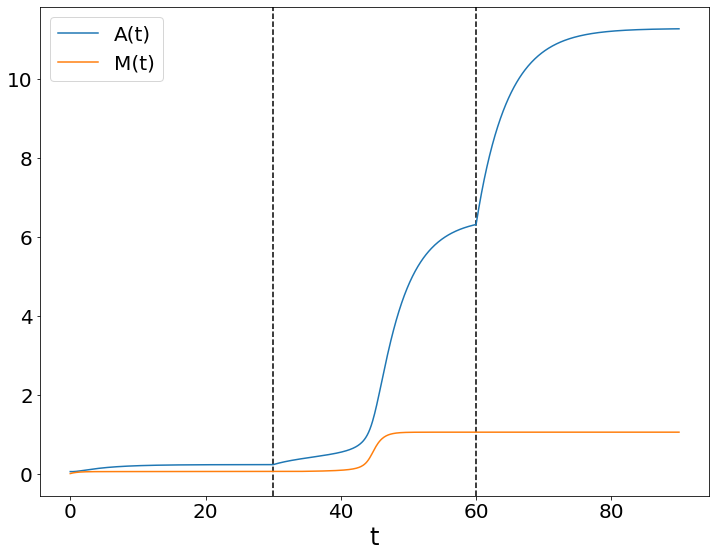

In [ ]:
def lac_operon_excercise_d(x0):

    system = lac_operon_system(1)

    t0 = np.linspace(0, 30, 301)
    sol0 = system.evolve_system(x0, t0)

    system.L = 2
    x1 = sol0[-1]
    t1 = np.linspace(30, 60, 301)
    sol1 = system.evolve_system(x1, t1)

    system.L = 3
    x2 = sol1[-1]
    t2 = np.linspace(60, 90, 301)
    sol2 = system.evolve_system(x2, t2)

    # Combine the solutions 
    t = np.concatenate((t0, t1, t2))
    sol = np.concatenate((sol0, sol1, sol2))

    ymin, ymax = np.min(sol), np.max(sol)

    plt.axvline(30, ls="--", color="k")
    plt.axvline(60, ls="--", color="k")
    plt.plot(t, sol[:, 0], label="A(t)")
    plt.plot(t, sol[:, 1], label="M(t)")
    plt.legend()
    plt.xlabel("t")
    plt.show()

x0 = [0.05, 0]
lac_operon_excercise_d(x0)

# Question 4

In [10]:
def system_ionic(states, t, k1, k2, k3):
    x, y, z = states
    
    return np.array([k2 * y - k1 * x, k1 * x - (k2 + k3) * y, k3 * y])

def plot_ionic_over_time(initial_state, initial_ks, filename, t_values = np.linspace(0, 10, 50)):
    x0, y0, z0, = initial_state
    k1, k2, k3 = initial_ks
    
    rates = odeint(system_ionic, y0 = initial_state, t = t_values, args = (k1, k2, k3)).transpose()
    plt.figure()
    plt.plot(t_values, rates[0], label=f"x")
    plt.plot(t_values, rates[1], label=f"y")
    plt.plot(t_values, rates[2], label=f"z")

    plt.xlabel("t")
    plt.ylabel("fraction")
    plt.legend()
    plt.savefig(f"Figures/{filename}.png", format="png", dpi=300)
#     plt.show()
    
    print(f"Final x: {rates[0, -1]} \nFinal y: {rates[1, -1]} \nFinal z: {rates[2, -1]}")
    
def nullcline_x(x, k1, k2, k3):
    """ 
    Analytical solution for the nullcline of x. The nullcline is written as a
    funtion of x. The nullcline was found by solving dx/dt=0.
    """

    return x * k1 / k2

def nullcline_y(x, k1, k2, k3):
    """ 
    Analytical solution for the nullcline of y. The nullcline is written as a
    funtion of x. The nullcline was found by solving dy/dt=0.
    """

    return x * k1 / (k2 + k3)

def plot_ionic_streamplot(xs, ys, k_values):
    """
    Plot the streamplot for the ionic channels for the given values in xs and ys. 
    The nullclines are also plotted.
    """

    k1, k2, k3 = k_values

    # Calculate dx/dt, dy/dt for all values of x and y
    x_velocities, y_velocities = [], []
    for y in ys:

        x_temp, y_temp = [], []
        for x in xs:
            
            change = system_ionic((x, y, 0), None, k1, k2, k3)
            x_temp.append(change[0])
            y_temp.append(change[1])

        x_velocities.append(x_temp)
        y_velocities.append(y_temp)

    x_velocities = np.array(x_velocities)
    y_velocities = np.array(y_velocities)

    # Compute nullcline
    x_nulls = nullcline_x(xs, k1, k2, k3)
    y_nulls = nullcline_y(xs, k1, k2, k3)

    plt.streamplot(xs, ys, x_velocities, y_velocities, density=1.5)
    
    plt.plot(xs, x_nulls, label="dx/dt = 0")
    plt.plot(xs, y_nulls, label="dy/dt = 0")
    
    plt.xlabel("x")
    plt.ylabel("y")

    plt.legend()
    plt.show()

## 4b

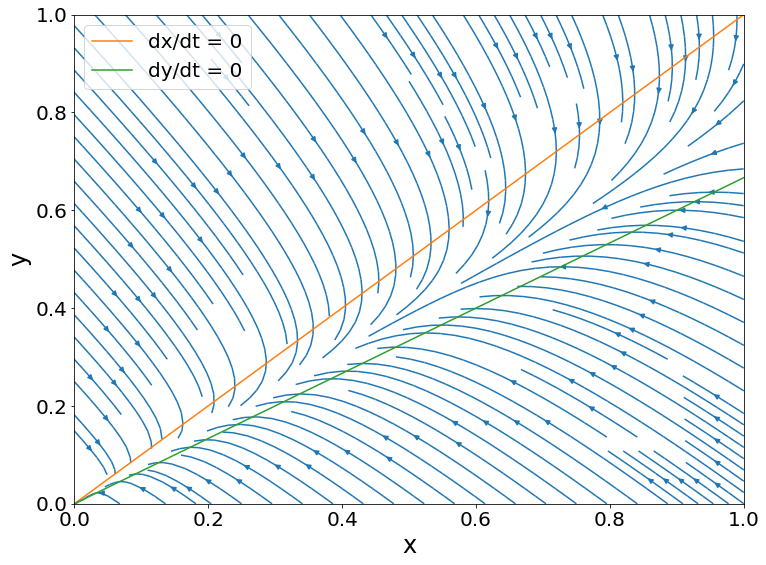

In [ ]:
xs = np.linspace(0, 1, 101)
ys = np.linspace(0, 1, 101)
k_values = (2, 2, 1)

plot_ionic_streamplot(xs, ys, k_values)

## 4c

Final x: 0.00774686801123593 
Final y: 0.006048573168352151 
Final z: 0.9862045588204112
Final x: 0.006048547358509574 
Final y: 0.004722581885518505 
Final z: 0.9892288707559719


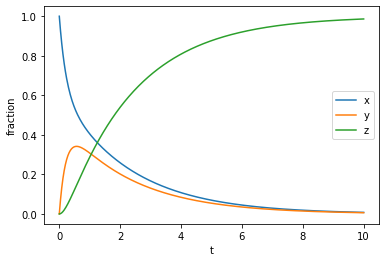

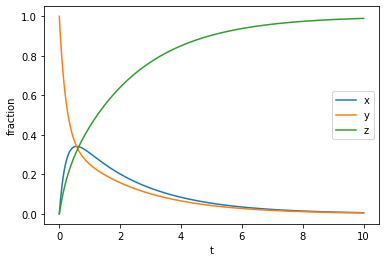

In [11]:
plot_ionic_over_time((1, 0, 0), (2, 2, 1), filename="4c_100", t_values=np.linspace(0, 10, 500))
plot_ionic_over_time((0, 1, 0), (2, 2, 1), filename="4c_010", t_values=np.linspace(0, 10, 500))

## 4f

Final x: 0.6666666667337748 
Final y: -1.006626447010223e-10 
Final z: 0.3333333333668874


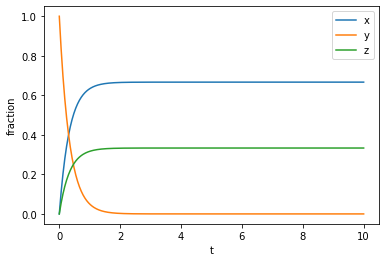

In [12]:
plot_ionic_over_time((0, 1, 0), (0, 2, 1), filename="4f", t_values=np.linspace(0, 10, 500))

## 4j

In [13]:
print("For {k2, k3} = {2, 1}:")
print(f"Theoretical x* = {2/(2+1)}")
print(f"Theoretical z* = {1/(2+1)}")

For {k2, k3} = {2, 1}:
Theoretical x* = 0.6666666666666666
Theoretical z* = 0.3333333333333333
